In [2]:
!pip install rasterio
!pip install geopandas

  Using cached rasterio-1.3.10-cp310-cp310-manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl.metadata (3.4 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached rasterio-1.3.10-cp310-cp310-manylinux2014_x86_64.whl (21.5 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached geopandas-0.14.4-py3-none-any.whl.metadata (1.5 kB)
  Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x86_64.whl.metadata (50 kB)
  Using cached pyproj-3.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
Using cached geopandas-0.14.4-py3-none-any.whl (1.1 MB)
Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x

In [2]:
from google.cloud import storage
import os


def download_file_from_gcs(bucket_name, source_blob_name, destination_folder):
    client = storage.Client()

    # Get the bucket
    bucket = client.get_bucket(bucket_name)

    # Get the specific blob
    blob = bucket.blob(source_blob_name)

    # Define destination path
    destination_path = os.path.join(destination_folder, os.path.basename(source_blob_name))
    print(destination_path)
    # Check if file already exists locally
    if not os.path.exists(destination_path):
        blob.download_to_filename(destination_path)
        print(f"Downloaded: {source_blob_name}")
    else:
        print(f"Skipped (already exists): {source_blob_name}")


username = os.getenv("USER") or os.getenv("LOGNAME")

# Replace these with your specific details
bucket_name = 'gislogics-bucket'
source_blob_name = 'area2_planetlabs_superdove/'
destination_folder = '/home/jupyter/image_folder/'

download_file_from_gcs(bucket_name, source_blob_name, destination_folder)



/home/jupyter/image_folder/
Skipped (already exists): area2_planetlabs_superdove/


In [3]:
from google.cloud import storage
import os


def download_files_from_gcs(bucket_name, source_folder_name, destination_folder):
    client = storage.Client()

    # Get the bucket
    bucket = client.get_bucket(bucket_name)

    # List all blobs with prefix (folder path)
    blobs = bucket.list_blobs(prefix=source_folder_name)

    for blob in blobs:
        # Get the relative path of the blob within the subfolder
        relative_path = os.path.relpath(blob.name, source_folder_name)

        # Define destination path
        destination_path = os.path.join(destination_folder, relative_path)

        # Ensure destination directory exists
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Check if file already exists locally
        if not os.path.exists(destination_path):
            blob.download_to_filename(destination_path)
            print(f"Downloaded: {blob.name}")
        else:
            print(f"Skipped (already exists): {blob.name}")


username = os.getenv("USER") or os.getenv("LOGNAME")

# Replace these with your specific details
bucket_name = 'gislogics-bucket'
source_folder_name = 'area2_planetlabs_superdove/'
destination_folder = '/home/jupyter/image_folder/'

download_files_from_gcs(bucket_name, source_folder_name, destination_folder)


Downloaded: area2_planetlabs_superdove/Copy of area2_0530_2022_8bands.tif
Downloaded: area2_planetlabs_superdove/area2_0516_2023_8bands.tif
Downloaded: area2_planetlabs_superdove/area2_0516_2023_composite.tif
Downloaded: area2_planetlabs_superdove/area2_0529_2023_composite.tif
Skipped (already exists): area2_planetlabs_superdove/area2_0530_2022_8bands.tif
Downloaded: area2_planetlabs_superdove/area2_0609_2023_composite.tif
Downloaded: area2_planetlabs_superdove/area2_0617_2023_8bands.tif
Downloaded: area2_planetlabs_superdove/area2_0626_2023_composite.tif
Downloaded: area2_planetlabs_superdove/area2_0909_2023_composite.tif
Downloaded: area2_planetlabs_superdove/area2_0927_2023_composite.tif


In [6]:
# Replace these with your specific details
bucket_name = 'tf_records_bucket'
source_blob_name = 'labels/continuous_label_raster.tif'
destination_folder = '/home/jupyter/label_folder/'

# download_file_from_gcs(bucket_name, source_blob_name, destination_folder)

/home/jupyter/label_folder/continuous_label_raster.tif
Downloaded: labels/continuous_label_raster.tif


In [7]:
# Replace these with your specific details
bucket_name = 'tf_records_bucket'
source_blob_name = 'labels/newextent_1123.geojson'
destination_folder = '/home/jupyter/label_folder/'

download_file_from_gcs(bucket_name, source_blob_name, destination_folder)

/home/jupyter/label_folder/newextent_1123.geojson
Downloaded: labels/newextent_1123.geojson


In [4]:
#TF Record Creation: Convert given input 8-band tiff file and label tiff file to tf records

import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import glob
from google.cloud import storage


# Specify the folder path where your images are located
folder_path = '/home/jupyter/image_folder/'

# Specify the folder path where your labels are located
label_folder = '/home/jupyter/label_folder/'

#Specify the path where your clipping mask are located
geojson_datapath = '/home/jupyter/label_folder/newextent_1123.geojson'

# Specify the GCS bucket name

bucket_name = 'tf_records_bucket'

# Specify the GCS path for TFRecords
gcs_output_dir = f'gs://{bucket_name}/baseline_test/'

def create_gcs_bucket(bucket_name):
    # Create a GCS client
    client = storage.Client()

    # Create a GCS bucket
    bucket = client.bucket(bucket_name)
    if not bucket.exists():
        bucket.create()


def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)

    with rasterio.open(tiff) as src:
        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)

    return clip_image

# preprocessing functions

def resize_img(image,label):
  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])
  return image, label


def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])

    if tensor_label.shape[:2] != tensor_image.shape[:2]:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    return tensor_image, tensor_label


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(image, label):
    image = clip_tiff(image)
    label = clip_tiff(label)
    image, label = process_input(image, label)
    image_dims = image.shape
    label_dims = label.shape

    image = tf.reshape(image, [-1])  # flatten to 1D array
    label = tf.reshape(label, [-1])  # flatten to 1D array

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _float_feature(image.numpy()),
                "image_shape": _int64_feature(
                    [image_dims[0], image_dims[1], image_dims[2]]
                ),
                "label": _float_feature(label.numpy()),
                "label_shape": _int64_feature([label_dims[0], label_dims[1], label_dims[2]]),
            }
        )
    ).SerializeToString()

def write_tfrecords(images, labels, gcs_output_directory):
    create_gcs_bucket(bucket_name)

    for image, label in zip(images, labels):
        # Create GCS path for TFRecord
        output_file_gcs = os.path.join(gcs_output_directory, f"{image.replace(folder_path,'').replace('.tif','')}_tfrecord.tfrecord")
        print(output_file_gcs)

        # Open a GCS file for writing
        with tf.io.TFRecordWriter(output_file_gcs) as writer:
            tf_example_bytes = create_tfrecord(image, label)
            writer.write(tf_example_bytes)




images = glob.glob(folder_path + '*.tif')  # list of file locations of all images
number_of_images = len(images)
labels = glob.glob(label_folder + '*.tif')
labels = labels * number_of_images
write_tfrecords(images, labels, gcs_output_dir)

2024-05-15 02:29:34.757825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 02:29:43.480458: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 02:29:58.118942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-05-15 02:29:58.119181: W tensorflow/strea

gs://tf_records_bucket/baseline_test/area2_0609_2023_composite_tfrecord.tfrecord


2024-05-15 02:30:18.694426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 02:30:19.930631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 02:30:19.933957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 02:30:20.062338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

gs://tf_records_bucket/baseline_test/area2_0617_2023_8bands_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0626_2023_composite_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0909_2023_composite_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0529_2023_composite_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0516_2023_composite_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/Copy of area2_0530_2022_8bands_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0516_2023_8bands_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0530_2022_8bands_tfrecord.tfrecord
gs://tf_records_bucket/baseline_test/area2_0927_2023_composite_tfrecord.tfrecord


In [5]:
pwd

'/home/jupyter'

In [6]:

import os
import tensorflow as tf
from google.cloud import storage


feature_description = {
    "image": tf.io.VarLenFeature(tf.float32),
    "image_shape": tf.io.VarLenFeature(tf.int64),
    "label": tf.io.VarLenFeature(tf.float32),
    "label_shape": tf.io.VarLenFeature(tf.int64),
}


def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)


def create_dataset(input_directory):
    tfrecord_files = [
        f"{input_directory}{file}"
        for file in tf.io.gfile.listdir(input_directory)
        if file.endswith(".tfrecord")
    ]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse)
    return dataset



# pre-processing functions
def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Convert the input_tensor to a float32 type
    input_tensor = tf.cast(input_tensor, tf.float32)

    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor


def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image


def tile_image(fullimg, CHANNELS, TILE_HT, TILE_WD):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    return tiles


def sampling(label_image, threshold_percentage=99.9):
    num_zeros = tf.reduce_sum(
        tf.cast(tf.equal(label_image, 0), tf.float32), axis=[2, 3, 4]
    )

    # Calculate the total number of elements in each patch
    total_elements = tf.cast(tf.reduce_prod(tf.shape(label_image)[2:]), tf.float32)

    # Calculate the percentage of zeros in each patch
    percentage_zeros = (num_zeros / total_elements) * 100.0

    boolean_mask = percentage_zeros <= threshold_percentage
    # Apply the threshold logic
    sampled_tensor = tf.cast(percentage_zeros >= threshold_percentage, tf.int32)
    return boolean_mask, sampled_tensor


def one_hot_encoding(label_tensor):
    # Assuming your pixel values are float labels
    float_labels = tf.squeeze(
        label_tensor, axis=-1
    )  # Assuming channel dimension is the last one

    # Determine the number of classes dynamically
    num_classes = tf.cast(tf.reduce_max(float_labels) + 1, tf.int32)

    # One-hot encode each image
    one_hot_encoded_images = tf.one_hot(
        tf.dtypes.cast(float_labels, tf.int32), depth=num_classes
    )

    # Print the shape of the resulting tensor and the number of classes
    # print("Shape of one-hot encoded images:", one_hot_encoded_images.shape)
    # print("Number of classes:", num_classes)

    return one_hot_encoded_images


def parsing(
    dataset,
    patch_height,
    patch_width,
    threshold_percentage,
    image_channels,
    label_channels,
):
    image_patch_tensors_list = []
    label_patch_tensors_list = []

    for parsed_example in dataset:
        image_shape = tf.sparse.to_dense(parsed_example["image_shape"])
        image = tf.reshape(tf.sparse.to_dense(parsed_example["image"]), image_shape)
        label_shape = tf.sparse.to_dense(parsed_example["label_shape"])
        label = tf.reshape(tf.sparse.to_dense(parsed_example["label"]), label_shape)

        # image normalization
        image = bandwise_normalize(image)

        # image and label patching
        image_patches = tile_image(image, image_channels, patch_height, patch_width)
        label_patches = tile_image(label, label_channels, patch_height, patch_width)

        # sampling
        sampled_mask, sampled_tensor = sampling(label_patches, threshold_percentage)
        sampled_image_patches = tf.boolean_mask(image_patches, sampled_mask)
        sampled_label_patches = tf.boolean_mask(label_patches, sampled_mask)

        # one-hot encoding
        sampled_label_patches = one_hot_encoding(sampled_label_patches)

        # save them in the list
        image_patch_tensors_list.append(sampled_image_patches)
        label_patch_tensors_list.append(sampled_label_patches)

    return image_patch_tensors_list, label_patch_tensors_list


def train_test_datasets(
    input_directory,
    patch_height,
    patch_width,
    image_channels,
    label_channels,
    threshold_percentage,
    batch_size,
):
    dataset = create_dataset(input_directory)
    image_patch_tensors_list, label_patch_tensors_list = parsing(
        dataset=dataset,
        patch_height=patch_height,
        patch_width=patch_width,
        image_channels=image_channels,
        label_channels=label_channels,
        threshold_percentage=threshold_percentage,
    )

    # Combine images and labels from different pairs
    combined_images = tf.concat(image_patch_tensors_list, axis=0)
    combined_labels = tf.concat(label_patch_tensors_list, axis=0)

    # Shuffle the combined data
    combined_dataset = tf.data.Dataset.from_tensor_slices(
        (combined_images, combined_labels)
    )
    combined_dataset = combined_dataset.shuffle(buffer_size=combined_images.shape[0])

    # Split the combined dataset into training and validation sets
    train_size = int(0.8 * combined_images.shape[0])
    train_dataset = combined_dataset.take(train_size)
    val_dataset = combined_dataset.skip(train_size)

    # Batch the data using TensorFlow's Dataset API
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset


In [26]:
gcs_tfrecords = 'gs://tf_records_bucket/baseline_test/'
patch_height = 16
patch_width = 16
image_channels = 8
label_channels = 1
threshold_percentage = 99
batch_size = 32

train_dataset, val_dataset = train_test_datasets(
    gcs_tfrecords,
    patch_height,
    patch_width,
    image_channels,
    label_channels,
    threshold_percentage,
    batch_size,
)


InvalidArgumentError: {{function_node __wrapped__Pack_N_3_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [231,287,16,16,1] != values[1].shape = [66297,16,16,1] [Op:Pack]

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [9]:

from tensorflow.keras.layers import Input, Conv2D, Dropout, Conv2DTranspose, UpSampling2D, concatenate

def r_multi_unet_model(n_classes=21, IMG_HEIGHT=16, IMG_WIDTH=16, IMG_CHANNELS=8):
  # Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

  # Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)

  # Use strided convolutions instead of pooling
  c2 = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(c1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)

  c3 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(c2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

  c4 = Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(c3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

  # Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  c4_up = UpSampling2D(size=(2, 2))(c4)  # Upsample c4 to match u6 dimensions
  u6 = concatenate([u6, c4_up], axis=3)
  c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  c3_up = UpSampling2D(size=(2, 2))(c3)  # Upsample c3 to match u7 dimensions
  u7 = concatenate([u7, c3_up], axis=3)
  c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  c2_up = UpSampling2D(size=(2, 2))(c2)  # Upsample c2 to match u8 dimensions
  u8 = concatenate([u8, c2_up], axis=3)
  c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

  # Output layer
  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c8)  # Corrected typo (Conv2D, not Conv2)
    
  model = Model(inputs=[inputs], outputs=[outputs])
  return model
 


In [10]:
def get_model():
  model = r_multi_unet_model(n_classes=21, IMG_HEIGHT=16, IMG_WIDTH=16, IMG_CHANNELS=8)
  print(model)
  return model  # Ensure model is returned

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 8)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   1168        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 16)   2320        ['dropout[0][0]']                
                                                                                              

In [13]:
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

model_path = "/home/jupyter/trained_models_srikar/"
model_name = f'model_{current_time}.h5'

# Define a callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_path + "best_epoch_" + model_name, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# TensorBoard callback to log training metrics
log_dir = "/home/jupyter/logs/" + current_time
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# CSVLogger callback to save training logs in CSV format
csv_logger = CSVLogger(model_path + "training_logs.csv", separator=',', append=False)

callbacks = [checkpoint, tensorboard, csv_logger]

model_history = model.fit(
    train_dataset,
    epochs=1000,
    batch_size=32,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Save the model
model.save(model_path + model_name)
print("model saved locally")


Epoch 1/1000
760/762 [============================>.] - ETA: 0s - loss: 1.1795 - accuracy: 0.5810
Epoch 1: val_loss improved from inf to 1.17726, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_02-51-42.h5
762/762 [==============================] - 10s 13ms/step - loss: 1.1795 - accuracy: 0.5810 - val_loss: 1.1773 - val_accuracy: 0.5783
Epoch 2/1000
759/762 [============================>.] - ETA: 0s - loss: 1.1539 - accuracy: 0.5805
Epoch 2: val_loss improved from 1.17726 to 1.13073, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_02-51-42.h5
762/762 [==============================] - 9s 12ms/step - loss: 1.1539 - accuracy: 0.5806 - val_loss: 1.1307 - val_accuracy: 0.5781
Epoch 3/1000
762/762 [==============================] - ETA: 0s - loss: 1.1435 - accuracy: 0.5818
Epoch 3: val_loss improved from 1.13073 to 1.12289, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_02-51-42.h5
762/762 [====

In [ ]:
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

model_path = "/home/jupyter/trained_models_srikar/"
model_name = f'model_{current_time}.h5'

# Load the existing model
existing_model_path = "/home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_02-51-42.h5"
existing_model = tf.keras.models.load_model(existing_model_path)

# Define a callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_path + "best_epoch_" + model_name, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# TensorBoard callback to log training metrics
log_dir = "/home/jupyter/logs/" + current_time
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# CSVLogger callback to save training logs in CSV format
csv_logger = CSVLogger(model_path + "training_logs.csv", separator=',', append=False)

callbacks = [checkpoint, tensorboard, csv_logger]

# Assuming `model` is your new model
# Set the weights of the new model to be the same as the existing model
model.set_weights(existing_model.get_weights())

model_history = model.fit(
    train_dataset,
    epochs=1000,
    batch_size=32,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Save the model
model.save(model_path + model_name)
print("model saved locally")


Epoch 1/1000
761/762 [============================>.] - ETA: 0s - loss: 0.5690 - accuracy: 0.7961
Epoch 1: val_loss improved from inf to 0.51358, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_05-39-21.h5
762/762 [==============================] - 9s 12ms/step - loss: 0.5689 - accuracy: 0.7962 - val_loss: 0.5136 - val_accuracy: 0.8247
Epoch 2/1000
761/762 [============================>.] - ETA: 0s - loss: 0.5735 - accuracy: 0.7931
Epoch 2: val_loss improved from 0.51358 to 0.47157, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_05-39-21.h5
762/762 [==============================] - 9s 12ms/step - loss: 0.5735 - accuracy: 0.7931 - val_loss: 0.4716 - val_accuracy: 0.8308
Epoch 3/1000
762/762 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7934
Epoch 3: val_loss did not improve from 0.47157
762/762 [==============================] - 9s 12ms/step - loss: 0.5790 - accuracy: 0.7934 - val_loss: 0.5199 - 

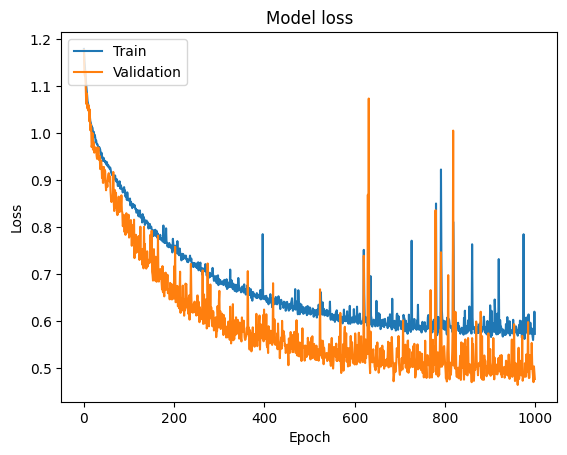

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

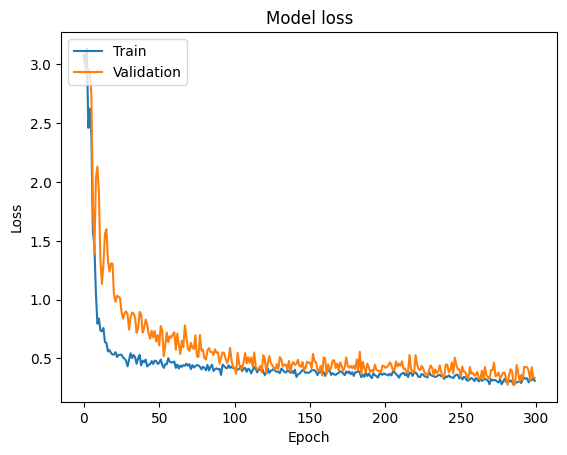

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

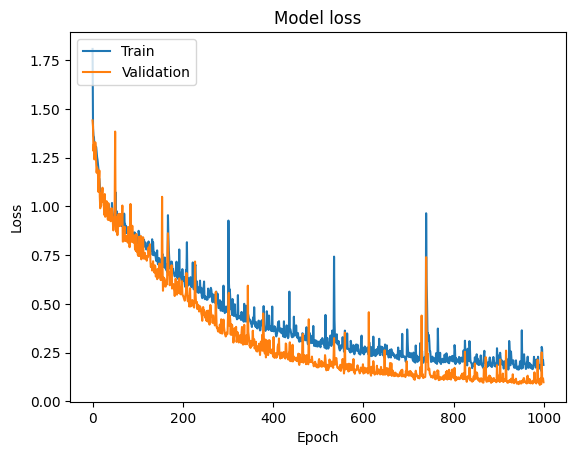

In [111]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model_training_visualization.png')

In [96]:
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

model_path = "/home/jupyter/trained_models_srikar/"
model_name = f'model_{current_time}.h5'

# Define a callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_path + "best_epoch_" + model_name, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# TensorBoard callback to log training metrics
log_dir = "/home/jupyter/logs/" + current_time
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# CSVLogger callback to save training logs in CSV format
csv_logger = CSVLogger(model_path + "training_logs.csv", separator=',', append=False)

callbacks = [checkpoint, tensorboard, csv_logger]

model_history = model.fit(
    train_dataset,
    epochs=1000,
    batch_size=32,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Save the model
model.save(model_path + model_name)
print("model saved locally")


Epoch 1/1000
77/77 [==============================] - ETA: 0s - loss: 1.8085 - accuracy: 0.4839
Epoch 1: val_loss improved from inf to 1.44134, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-04-01_03-02-23.h5
77/77 [==============================] - 4s 32ms/step - loss: 1.8085 - accuracy: 0.4839 - val_loss: 1.4413 - val_accuracy: 0.5720
Epoch 2/1000
76/77 [============================>.] - ETA: 0s - loss: 1.3999 - accuracy: 0.5746
Epoch 2: val_loss improved from 1.44134 to 1.40990, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-04-01_03-02-23.h5
77/77 [==============================] - 1s 18ms/step - loss: 1.4011 - accuracy: 0.5743 - val_loss: 1.4099 - val_accuracy: 0.5212
Epoch 3/1000
76/77 [============================>.] - ETA: 0s - loss: 1.3635 - accuracy: 0.5763
Epoch 3: val_loss improved from 1.40990 to 1.28454, saving model to /home/jupyter/trained_models_srikar/best_epoch_model_2024-04-01_03-02-23.h5
77/77 [=================

In [3]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import time
from datetime import datetime
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys

geojson_datapath = '/home/jupyter/label_folder/newextent_1123.geojson'


def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)

    with rasterio.open(tiff) as src:
        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)

    return clip_image

def tensorify_image(image):
    ## resizing and process input funciton condensed into one.
    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    return tensor_image


def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Convert the input_tensor to a float32 type
    input_tensor = tf.cast(input_tensor, tf.float32)

    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor


def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image


def tile_image(fullimg, CHANNELS=1, TILE_HT=128, TILE_WD=128):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    all_tiles = tf.reshape(tiles, [nrows * ncols, TILE_HT, TILE_WD, CHANNELS])
    ordered_tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    return ordered_tiles, all_tiles, fullimg.shape



def stitch_segmentation_patches(segmentation_patches, dims, PATCH_HEIGHT, PATCH_WIDTH):
    height, width = dims[0], dims[1]
    num_rows, num_cols = segmentation_patches.shape[:2]

    # Convert TensorFlow tensor to NumPy array
    segmentation_patches_np = segmentation_patches.numpy()

    stitched_array = np.zeros((height, width), dtype=int)

    # Reshape the segmentation_patches array
    segmentation_patches_reshaped = segmentation_patches_np.reshape(
        (num_rows, num_cols, PATCH_HEIGHT, PATCH_WIDTH)
    )
    print("segmentation_patches_reshaped.shape", segmentation_patches_reshaped.shape)

    # Calculate the indices for stitching
    row_indices_patch = np.arange(0, height, PATCH_HEIGHT)
    col_indices_patch = np.arange(0, width, PATCH_WIDTH)
    print("row_indices_patch", row_indices_patch.shape)
    print("col_indices_patch", col_indices_patch.shape)

    # Use nested loops to stitch patches into the final array
    for i in range(num_rows):
        for j in range(num_cols):
            row_start = row_indices_patch[i]
            col_start = col_indices_patch[j]
            row_end = row_start + PATCH_HEIGHT
            col_end = col_start + PATCH_WIDTH

            stitched_array[
                row_start:row_end, col_start:col_end
            ] = segmentation_patches_reshaped[i, j]

    print("stitched_array", stitched_array.shape)
    return stitched_array


def prediction(test_image_path, model_path):
    IMAGE_CHANNELS = 8
    model = keras.models.load_model(model_path)
    input_shape = model.layers[0].input_shape

    PATCH_HEIGHT = input_shape[0][-3]
    PATCH_WIDTH = input_shape[0][-2]

    image = clip_tiff(test_image_path)
    new_image = tensorify_image(image)
    normalized_image = bandwise_normalize(new_image)
    display_patches, inference_patches, dims = tile_image(
        normalized_image, IMAGE_CHANNELS, PATCH_HEIGHT, PATCH_WIDTH
    )
    print("dims", dims)
    start_time = time.time()
    predictions = model.predict(inference_patches, batch_size=2048)
    end_time_pred = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time_pred - start_time

    # Print the elapsed time
    print(f"Time taken for predictions: {elapsed_time} seconds")

    logits = predictions

    # Set values of class 0 to a very large negative number
    mask = tf.one_hot(
        0, depth=21, on_value=float("-inf"), off_value=0, dtype=tf.float32
    )
    logits_with_mask = logits + mask

    # Perform argmax along the last axis (axis=-1)
    argmax_result = tf.argmax(logits_with_mask, axis=-1)

    tiles = display_patches
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    segmentation_patches = tf.reshape(
        argmax_result, [nrows, ncols, PATCH_HEIGHT, PATCH_WIDTH]
    )

    stitched_array = stitch_segmentation_patches(
        segmentation_patches, dims, PATCH_HEIGHT, PATCH_WIDTH
    )

    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time_stitch = end_time - start_time

    # Print the elapsed time
    print(f"Time taken including stitching: {elapsed_time_stitch} seconds")

    return argmax_result,stitched_array


def resize_img(image,label):
  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])
  print(image.shape, label.shape)
  return image, label


def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.expand_dims(tensor_image,-1)
    #tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])
    #tensor_label = tf.expand_dims(tensor_label,-1)


    if tensor_label.shape != tensor_image.shape:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    tensor_image = tf.squeeze(tensor_image)
    tensor_label = tf.squeeze(tensor_label)

    print(tensor_image.shape)
    print(tensor_label.shape)

    return tensor_image.numpy().astype(int), tensor_label.numpy().astype(int)


def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''

  class_names = [
    "lake",
    "settlement",
    "shrub land",
    "grass land",
    "homogenous forest",
    "agriculture1 (with vegetation)",
    "agriculture2 (without vegetation)",
    "open area",
    "clove plantation",
    "mixed forest1",
    "mixed forest2",
    "rice field1",
    "rice field2",
    "rice field3",
    "mixed garden",
    "grass land2",
    "grass land3",
    "mixed garden2",
    "agroforestry",
    "clouds"]


  class_wise_iou = []
  class_wise_dice_score = []
  class_wise_accuracy = []
  class_wise_precision = []
  class_wise_recall = []

  smoothening_factor = 0.00001

  print(np.unique(y_true)[1:])
  print(np.unique(y_pred))

  for i in np.unique(y_true)[1:]:

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

    # Accuracy
    accuracy = np.sum((y_pred == i) & (y_true == i)) / np.sum(y_true == i)
    class_wise_accuracy.append(accuracy)

    # Precision
    precision = intersection / (y_pred_area + smoothening_factor)
    class_wise_precision.append(precision)

    # Recall
    recall = intersection / (y_true_area + smoothening_factor)
    class_wise_recall.append(recall)

  # Mean IOU
  mean_iou = np.mean(class_wise_iou)



  return  class_wise_iou,class_wise_dice_score,class_wise_accuracy, class_wise_precision, class_wise_recall, mean_iou

def label_image_processing(predicted_array,label_image_path):

    ground_truth = clip_tiff(label_image_path)

    resized_predicted_array, new_ground_truth = process_input(predicted_array, ground_truth)

    new_boolean_mask = new_ground_truth != 0

    new_predict = np.where(new_boolean_mask,resized_predicted_array,0)

    return new_predict, new_ground_truth


2024-05-15 13:22:00.424686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:22:09.641220: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 13:22:23.525319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-05-15 13:22:23.525542: W tensorflow/strea

In [4]:

label_image_path = '/home/jupyter/label_folder/continuous_label_raster.tif'

geojson_datapath = '/home/jupyter/label_folder/newextent_1123.geojson'

model_path = '/home/jupyter/trained_models_srikar/model_2024-05-15_05-39-21.h5'

test_image_path = '/home/jupyter/image_folder/area2_0530_2022_8bands.tif'

a_r, predicted_array = prediction(test_image_path, model_path)

2024-05-15 13:23:19.855512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 13:23:21.512001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 13:23:21.515319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 13:23:21.519371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

dims (3696, 4560, 8)


2024-05-15 13:23:59.661343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


KeyboardInterrupt: 

In [99]:
import numpy as np
import tensorflow as tf

# Assuming argmax_result is a TensorFlow tensor
argmax_result_np = a_r.numpy()  # Convert TensorFlow tensor to NumPy array

# Get unique values
unique_values = np.unique(argmax_result_np)

print(unique_values)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [32]:
unique_values = np.unique()

In [33]:
unique_values

array([ 0,  9, 10])

In [5]:

label_image_path = '/home/jupyter/label_folder/continuous_label_raster.tif'

geojson_datapath = '/home/jupyter/label_folder/newextent_1123.geojson'

model_path = '/home/jupyter/trained_models_srikar/best_epoch_model_2024-05-15_02-51-42.h5'

test_image_path = '/home/jupyter/image_folder/area2_0530_2022_8bands.tif'

l, predicted_array = prediction(test_image_path, model_path)
new_predict, ground_truth_array = label_image_processing(predicted_array,label_image_path)

eval_results = compute_metrics(ground_truth_array, new_predict)

dims (3696, 4560, 8)
33/33 [==============================] - 2s 65ms/step
Time taken for predictions: 4.175443887710571 seconds
segmentation_patches_reshaped.shape (231, 285, 16, 16)
row_indices_patch (231,)
col_indices_patch (285,)
stitched_array (3696, 4560)
Time taken including stitching: 5.486307144165039 seconds
(3694, 4583, 1) (3694, 4583, 1)
(3694, 4583)
(3694, 4583)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20]


In [18]:
ground_truth_array.dtype

dtype('int64')

In [17]:
new_predict.dtype

dtype('int64')

In [100]:
new_predict, ground_truth_array = label_image_processing(predicted_array,label_image_path)

eval_results = compute_metrics(ground_truth_array, new_predict)

(3694, 4583, 1) (3694, 4583, 1)
(3694, 4583)
(3694, 4583)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [101]:
eval_results

([0.99843720655713,
  0.9621420027006249,
  0.8943815765448053,
  0.8554710361162345,
  0.994460416524465,
  0.8741312746172538,
  0.9208860761419522,
  0.8785714298104956,
  0.9821134868604919,
  0.9710014208968923,
  0.9753704266407469,
  0.9089506186890337,
  0.9663355409317452,
  0.9182813818638546,
  0.9865104721813615,
  0.8758169944786193,
  0.8660508114076025,
  0.9371990790512893,
  0.6972477203097376,
  0.9983320978508776],
 [0.9992179922537859,
  0.9807057814586481,
  0.9442464903120451,
  0.9221065926803744,
  0.9972225155584071,
  0.9328388979545965,
  0.9588138398697076,
  0.9353612225129754,
  0.9909760403531915,
  0.9852873880891605,
  0.9875316685220987,
  0.9523039696660957,
  0.9828795972735342,
  0.9574000893611476,
  0.9932094371100619,
  0.9337979140514027,
  0.928217835046809,
  0.9675815874566872,
  0.8216216534696851,
  0.9991653530558906],
 [0.9985108766375326,
  0.9714387211367673,
  0.975319333189002,
  0.9593175853018373,
  0.9961368265786331,
  0.900556881

In [18]:
eval_results

([0.9984107079391904,
  0.8317522700692829,
  0.39901746834239915,
  0.5148471626313381,
  0.7364657274412195,
  0.23959828106313383,
  0.37460408958450325,
  0.004153696737760158,
  0.853545454678595,
  0.8936892400248729,
  0.8897405005520033,
  0.004893980344307009,
  0.5606490881122738,
  0.5540875318866897,
  0.7022593633480056,
  0.23057433082285192,
  0.12380954467120134,
  0.39843228919540985,
  5.0251253756218405e-08,
  0.8771714842221684],
 [0.9992047220386227,
  0.9081492994088154,
  0.5704252847308815,
  0.6797347957916766,
  0.8482352585802033,
  0.38657407874255184,
  0.5450356110755807,
  0.00827302990410517,
  0.9209868071406215,
  0.9438605038162955,
  0.9416536295140371,
  0.009740292049670585,
  0.7184819356401327,
  0.7130712025596824,
  0.8250909112271075,
  0.3747426329804898,
  0.22033902075552925,
  0.5698270738582862,
  1.0050250751243681e-07,
  0.9345672377439199],
 [0.9986919862356706,
  0.872113676731794,
  0.4747780904957783,
  0.7736220472440944,
  0.97654

In [9]:
class_wise_iou,class_wise_dice_score,class_wise_accuracy, class_wise_precision, class_wise_recall, mean_iou = eval_results

In [11]:

from sklearn.metrics import confusion_matrix
import numpy as np

# Flatten the arrays to 1D
ground_truth_flat = ground_truth_array.flatten()
predictions_flat = new_predict.flatten()

# Create the confusion matrix
conf_matrix = confusion_matrix(ground_truth_flat, predictions_flat)


In [7]:
class_names = [
    "lake",
    "settlement",
    "shrub land",
    "grass land",
    "homogenous forest",
    "agriculture1 (with vegetation)",
    "agriculture2 (without vegetation)",
    "open area",
    "clove plantation",
    "mixed forest1",
    "mixed forest2",
    "rice field1",
    "rice field2",
    "rice field3",
    "mixed garden",
    "grass land2",
    "grass land3",
    "mixed garden2",
    "agroforestry",
    "clouds",
]


In [10]:
import csv

class_names = [
    "lake",
    "settlement",
    "shrub land",
    "grass land",
    "homogenous forest",
    "agriculture1 (with vegetation)",
    "agriculture2 (without vegetation)",
    "open area",
    "clove plantation",
    "mixed forest1",
    "mixed forest2",
    "rice field1",
    "rice field2",
    "rice field3",
    "mixed garden",
    "grass land2",
    "grass land3",
    "mixed garden2",
    "agroforestry",
    "clouds",
]

class_metrics = {}

class_metrics["class_wise_iou"] = dict(zip(class_names, class_wise_iou))
class_metrics["class_wise_dice_score"] = dict(zip(class_names, class_wise_dice_score))
class_metrics["class_wise_accuracy"] = dict(zip(class_names, class_wise_accuracy))
class_metrics["class_wise_precision"] = dict(zip(class_names, class_wise_precision))
class_metrics["class_wise_recall"] = dict(zip(class_names, class_wise_recall))

# Writing to CSV
with open('class_metrics_all_images_1.csv', 'w', newline='') as csvfile:
    fieldnames = ['Class Name', 'Class Wise IoU', 'Class Wise Dice Score', 'Class Wise Accuracy', 'Class Wise Precision', 'Class Wise Recall']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for class_name in class_names:
        writer.writerow({
            'Class Name': class_name,
            'Class Wise IoU': class_metrics["class_wise_iou"][class_name],
            'Class Wise Dice Score': class_metrics["class_wise_dice_score"][class_name],
            'Class Wise Accuracy': class_metrics["class_wise_accuracy"][class_name],
            'Class Wise Precision': class_metrics["class_wise_precision"][class_name],
            'Class Wise Recall': class_metrics["class_wise_recall"][class_name]
        })

print("Data has been saved to class_metrics.csv")


Data has been saved to class_metrics.csv


In [ ]:
#1-lake
#2-settlement
#3-shrub land
#4-grass land
#5-homogenous forest
#6-agriculture1 (with vegetation)
#7-agriculture2 (without vegetation)
#8-open area
#9-clove plantation
#10-mixed forest1
#11-mixed forest2
#12-rice field1
#13-rice field2
#14-rice field3
#15-mixed garden
#16-grass land2
#17-grass land3
#18-mixed garden2
#19-agroforestry
#20-cloud



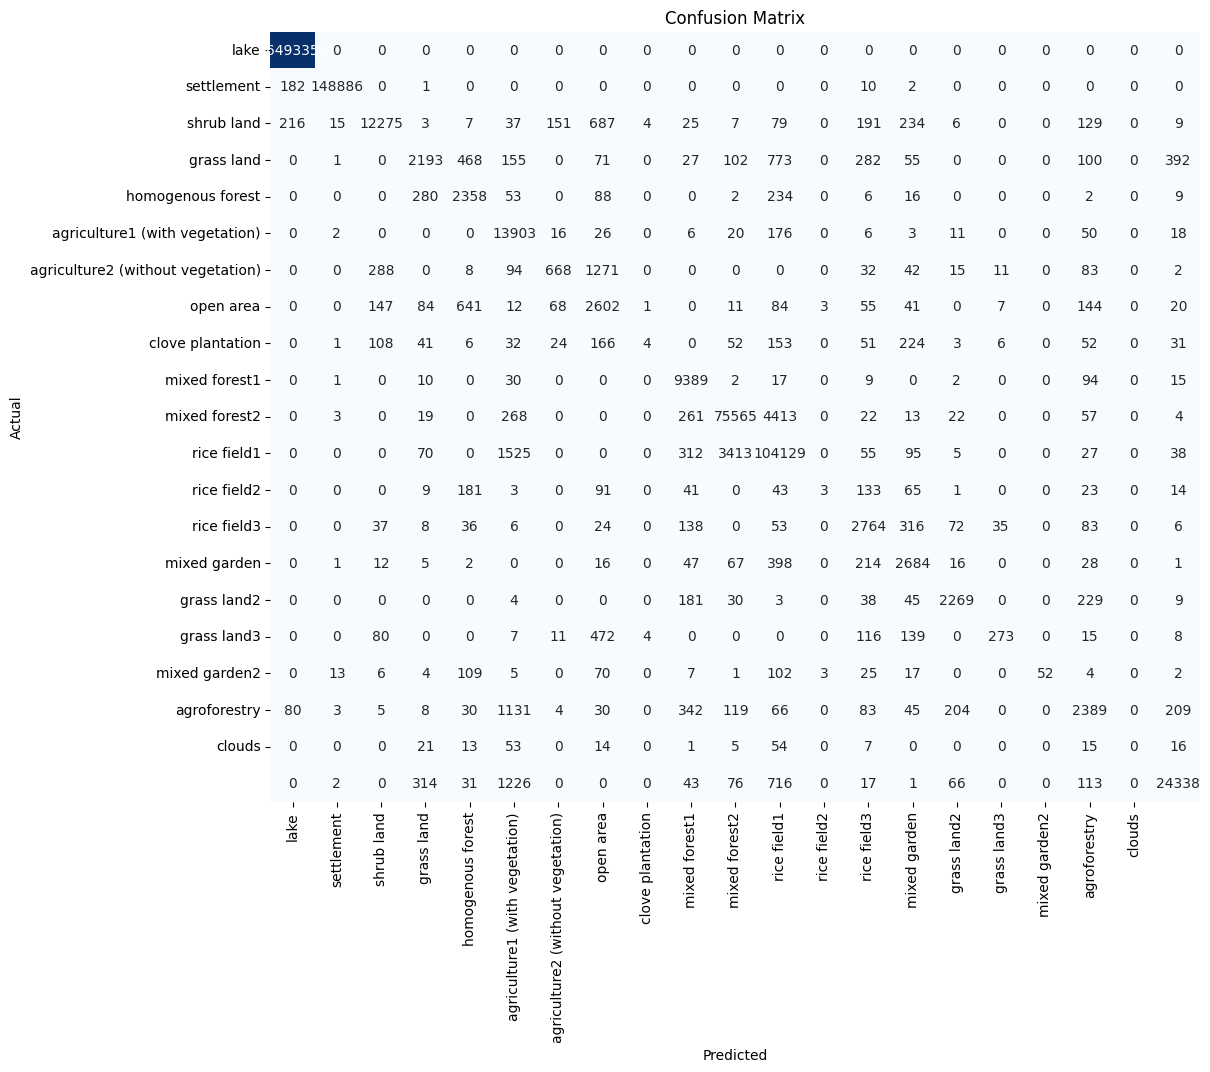

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# plt.show()

plt.savefig('confusion_all_images')


In [ ]:
1 5 5 230
2 190 60 15
3 65 240 125
4 105 200 95
5 30 115 10
6 255 196 34
7 110 85 5
8 235 235 220
9 120 216 47
10 84 142 128
11 84 142 128
12 50 255 215
13 50 255 215
14 50 255 215
15 193 255 0
16 105 200 95
17 105 200 95
18 193 255 0
19 255 50 185
20 255 255 255

In [13]:
def save_segmentation_mask(stitched_array):
    # Define the class-color mapping
    class_colors = {
        1: (5, 5, 230),
        2: (190, 60, 15),
        3: (65, 240, 125),
        4: (105, 200, 95),
        5: (30, 115, 10),
        6: (255, 196, 34),
        7: (110, 85, 5),
        8: (235, 235, 220),
        9: (120, 216, 47),
        10: (84, 142, 128),
        11: (84, 142, 128),
        12: (50, 255, 215),
        13: (50, 255, 215),
        14: (50, 255, 215),
        15: (193, 255, 0),
        16: (105, 200, 95),
        17: (105, 200, 95),
        18: (193, 255, 0),
        19: (255, 50, 185),
        20: (255, 255, 255)
    }

    # Create a colormap using the class-color mapping
    colors = [class_colors[i] for i in range(1, 21)]
    normalized_colors_array = np.array([tuple(np.array(v) / 255.0) for v in class_colors.values()])

    cmap = ListedColormap(normalized_colors_array)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 8))


    # Plot the segmentation mask using the custom colormap
    image = ax.imshow(stitched_array, cmap=cmap, vmin=1, vmax=20)

    # Add a colorbar to show the class-color mapping
    cbar = plt.colorbar(image, ax=ax, ticks=list(class_colors.keys()))
    cbar.set_label('Classes')

    # save the plot
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f'content/segmentation_mask_{current_time}.png'
    plt.savefig(filename)


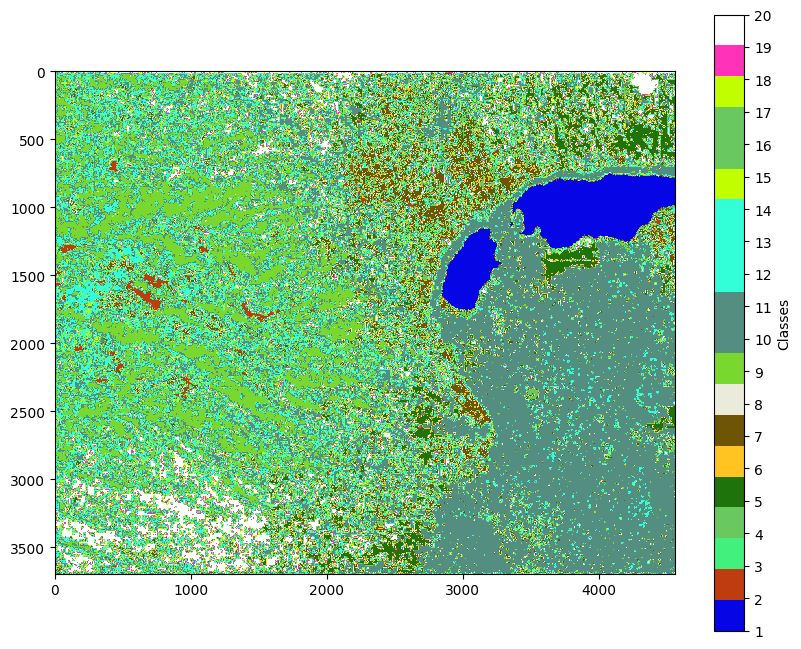

In [14]:
save_segmentation_mask(predicted_array)